## Quick Recap on Group Theory


 Quick recap on Groups
 
 **$\mathbf{O(3)}$** allows all orthogonal matrices $det= \pm 1$. Includes reflections; relevant if mirror images are indistinguishable in your task (many classical shape problems). An $O(3)$ transform acts as $x\mapsto Rx$; no translation is included, so the origin stays put. $O(3)$ **preserves lengths and angles** and hence dot products; it preserves chirality **only** when restricted to **SO(3)**.
  
 $\mathbf{SO(3)}$ is the “special orthogonal group”: $R^\top R=I$ and $\det R = +1$. Orthogonality preserves lengths and angles, and $\det=+1$ rules out reflections (if $det = -1$ then you get the inversion of the image)
 
$E(3)$ is the group of all Euclidean isometries of $\mathbb{R}^3$: maps that preserve pairwise distance
$\mathbf{E(3)}=\mathbb{R}^3\rtimes \mathbf{O(3)}$ (full Euclidean group): translations + rotations + reflections. Some 3D vision datasets treat mirrored scenes as equivalent; then E(3) invariants are appropriate. So $E(3)$ **strictly contains $O(3)$**: it adds the ability to move the whole space without changing shape.

## Rotation and Translation 

The rotation/reflection part is a $3×3$ matrix $R$; $R$ must be *orthogonal* and for $SO(3)$ have a positive determinant. if $R$ isn’t orthogonal, lengths and angles will not be preserved and we've left the Euclidean group.

The translation is a $3$-vector $t$. 

For a proper rotation (no mirror flip), its required $R^\top R=I$ and $\det R=+1$. If we allow reflections, then we keep $R^\top R=I$ but permit $\det R=-1$ -this will mess up with enantiomers though-.

All the standard ways to build R—axis–angle (Rodrigues), quaternions, or QR/SVD orthonormalization—boil down to the same condition: R must be orthogonal and, for SO(3), have positive determinant. Translation is always $x\mapsto x+t$. Inversion through the origin is just $x\mapsto -x$, i.e., $R=-I$ (orthogonal with $\det=-1$).

#### Rodrigues' formula

A 3D rotation is fully determined by an axis u (a unit 3-vector) and an angle $\theta$.

"Rotate about the x-axis by $\theta$” means: keep the x-coordinate fixed, rotate the y–z plane. Choose $u=\mathbf{e}_x=(1,0,0)$

“Rotate about the y-axis by $\theta$” means: keep y fixed, rotate the x–z plane. Choose $u=\mathbf{e}_y=(0,1,0)$.

For the z-axis, $u=\mathbf{e}_z=(0,0,1)$.

Rodrigues formula turns $(u,\theta)$ into a rotation:
$$
R = I\cos\theta + (1-\cos\theta)\,uu^\top + [u]\times \sin\theta
$$

where $[u]\times$ is the skew matrix with $[u]_\times v = u\times v$.

With $u=\mathbf{e}_x$, this becomes the familiar

$$
R_x(\theta)=\begin{pmatrix}
1&0&0\\[2pt]0&\cos\theta&-\sin\theta\\[2pt]0&\sin\theta&\cos\theta
\end{pmatrix}.
$$

With $u=\mathbf{e}_y$,
$$
R_y(\theta)=\begin{pmatrix}
\cos\theta&0&\sin\theta\\[2pt]0&1&0\\[2pt]-\sin\theta&0&\cos\theta
\end{pmatrix}
$$
and so on

# Basics of RDKit

For the basics of RDkit [Start here](https://education.molssi.org/python-data-science-chemistry/rdkit_descriptors/rdkit.html) that's pretty much all you will probably need. 



## To write SMILES
Writing SMILES (string representation for molecules) manually is simple:

Each atom is written in sequence, and single bonds are implied:
```
C → CH4
CC → CH3–CH3
CCC → CH3–CH2–CH3
```
Use parentheses for branches:    
```
CC(C)C → isobutane
(the (C) means a CH3 branch on the second carbon) 
    CH3
     |
CH3-CH2-CH3
```


Double and triple bonds:
```
C=C → ethene
C#C → ethyne
```

Rings use numbers to show where atoms connect back:
```
C1CCCCC1 → cyclohexane
C1=CC=CC=C1 → benzene
```

Add heteroatoms directly:
```
CCO → ethanol
CC(=O)O → acetic acid
```

Aromatic atoms are lowercase:
```
c1ccccc1 → benzene
c1ccncc1 → pyridine
```

General rule: write the main chain, add branches with parentheses, add rings with numbers, use = and # for multiple bonds. Hydrogens are implied.


`AllChem.EmbedMolecule()` uses RDKit’s ETKDG algorithm (Experimental-Torsion Knowledge Distance Geometry):

1.	Distance geometry:

- 	Estimates upper and lower distance bounds between atoms based on connectivity and ideal bond lengths/angles.

 - Randomly generates a 3D coordinate set consistent with those bounds.

2.	Torsion knowledge (ETKDG):

-	Incorporates known distributions of torsion angles from crystal structures.

-	Produces much more realistic conformations than vanilla distance geometry.

3.	Force field minimization (optional):

-	By default, EmbedMolecule() just embeds; it doesn’t minimize energy.

-	To minimize (relax) the structure, you can do:

In [370]:
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import Draw, AllChem
import numpy as np 
import py3Dmol
# Some helper functions

def smiles_to_2D(smiles:str):
    # Displays the molecule in 2D
    mol = Chem.MolFromSmiles(smiles)
    mol_2d_fig = Draw.MolToImage(mol)
    display(mol_2d_fig)

def smiles_to_3D_interactive(smiles:str, add_hydrogens:bool=True):
    mol = Chem.MolFromSmiles(smiles)
    if add_hydrogens:
        mol = Chem.AddHs(mol)

    # Generate 3D conformer with MMFF optimization
    AllChem.EmbedMolecule(mol, AllChem.ETKDG()) # type: ignore
    AllChem.MMFFOptimizeMolecule(mol) # type: ignore

    block = Chem.MolToMolBlock(mol) # block is the data type for 3D viz

    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(block, 'mol')
    viewer.setStyle({'stick': {}})
    viewer.zoomTo()
    
    display(viewer)


def get_3D_coords(smiles:str, optimize:bool=True, seed:int=42):
    try: mol = Chem.MolFromSmiles(smiles)
    except Exception as e: raise ValueError(f'Invalid Smiles raised exception{e}') 
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=seed)

    if optimize: AllChem.MMFFOptimizeMolecule(mol)  # MMFF94 force field

    conf = mol.GetConformer()

    coords = []
    for i, atom in enumerate( mol.GetAtoms()):
        pos = conf.GetAtomPosition(i)
        coords.append({
            'index': i,
            'symbol': atom.GetSymbol(),  # C, N, H, O ... 
            'x': pos.x,
            'y': pos.y, 
            'z': pos.z
        })

    return coords 

def smiles_to_3d_scatter(smiles:str, optimize:bool=True, seed:int=42):
    coords = get_3D_coords(smiles, optimize, seed) 
    # separate by element
    symbols = [a['symbol'] for a in coords]
    x = np.array([a['x'] for a in coords])
    y = np.array([a['y'] for a in coords])
    z = np.array([a['z'] for a in coords])

    # assign colors per element (simple scheme)
    color_map = {'C': 'black', 'O': 'red', 'N': 'blue', 'H': 'lightgray'}
    colors = [color_map.get(sym, 'orange') for sym in symbols]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # scatter plot atoms
    ax.scatter(x, y, z, c=colors, s=100, edgecolor='k') # type: ignore

    # label atoms
    for a in coords:
        ax.text(a['x'], a['y'], a['z'], a['symbol'], fontsize=10, ha='center', va='center')

    # set equal aspect ratio
    max_range = (x.max()-x.min(), y.max()-y.min(), z.max()-z.min())
    max_range = max(max_range)
    mid = [np.mean(x), np.mean(y), np.mean(z)]
    ax.set_xlim(mid[0]-max_range/2, mid[0]+max_range/2)
    ax.set_ylim(mid[1]-max_range/2, mid[1]+max_range/2)
    ax.set_zlim(mid[2]-max_range/2, mid[2]+max_range/2)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title("3D Conformer")

    plt.show()

def coords_to_3d_scatter(coords:list):
    # separate by element
    symbols = [a['symbol'] for a in coords]
    x = np.array([a['x'] for a in coords])
    y = np.array([a['y'] for a in coords])
    z = np.array([a['z'] for a in coords])

    # assign colors per element (simple scheme)
    color_map = {'C': 'black', 'O': 'red', 'N': 'blue', 'H': 'lightgray'}
    colors = [color_map.get(sym, 'orange') for sym in symbols]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # scatter plot atoms
    ax.scatter(x, y, z, c=colors, s=100, edgecolor='k') # type: ignore

    # label atoms
    for a in coords:
        ax.text(a['x'], a['y'], a['z'], a['symbol'], fontsize=10, ha='center', va='center')

    # set equal aspect ratio
    max_range = (x.max()-x.min(), y.max()-y.min(), z.max()-z.min())
    max_range = max(max_range)
    mid = [np.mean(x), np.mean(y), np.mean(z)]
    ax.set_xlim(mid[0]-max_range/2, mid[0]+max_range/2)
    ax.set_ylim(mid[1]-max_range/2, mid[1]+max_range/2)
    ax.set_zlim(mid[2]-max_range/2, mid[2]+max_range/2)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title("3D Conformer")

    plt.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

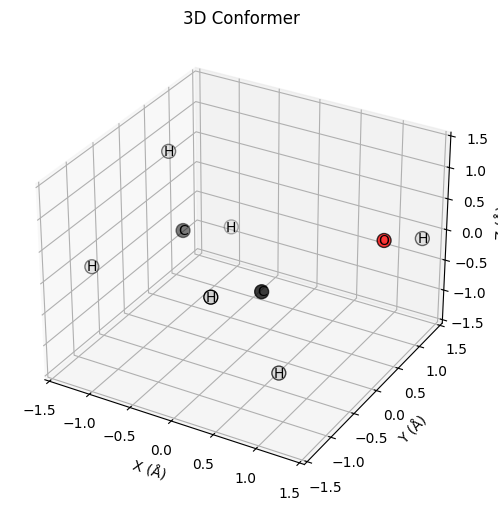

In [371]:
smiles_to_3D_interactive('CCO')
smiles_to_3d_scatter('CCO')

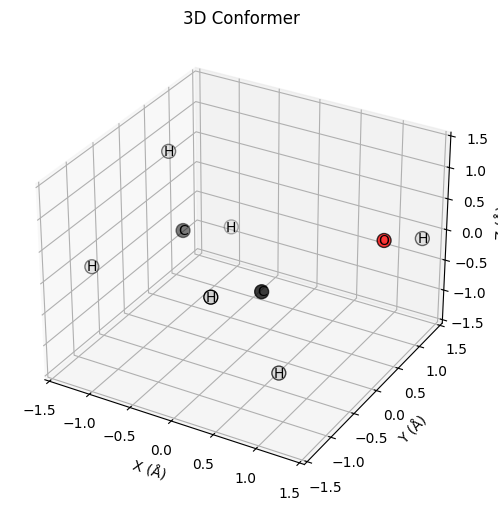

In [372]:
smiles = 'CCO'
coords = get_3D_coords('CCO')

x_coords = np.array([x['x'] for x in coords])
y_coords = np.array([y['y'] for y in coords])
z_coords = np.array([z['z'] for z in coords])

atoms_matrix = np.array((x_coords, y_coords,z_coords)).T # [X,Y,Z] matrix, each row is one atom vector

coords_to_3d_scatter(coords)


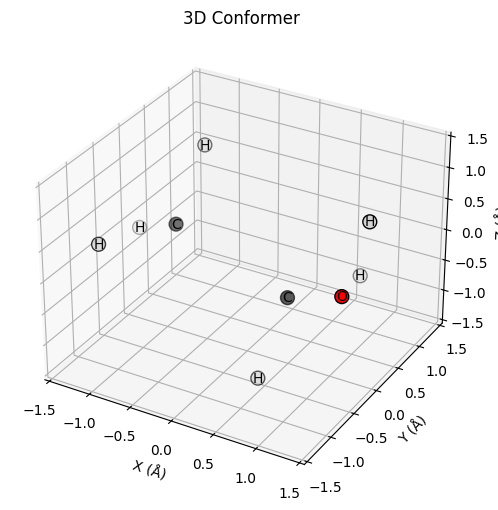

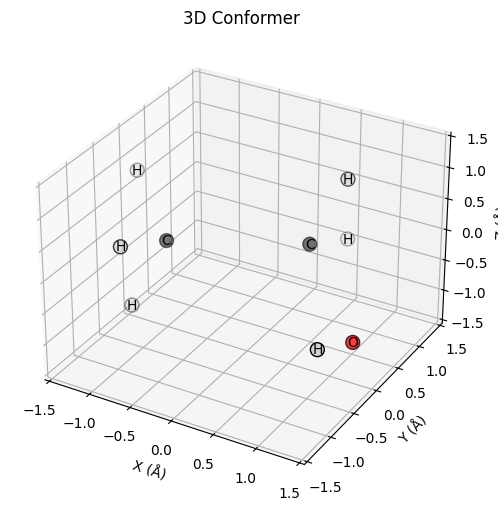

In [374]:
def R_axis_angle(axis:str, theta:int):
    """
    Rodrigues: u is 3-vector theta in radians returns R in SO(3).

    Arga:
        axis(str),  
        Theta is the angle in Degrees
    Rodrigues' formula
    R = I * cos(theta) + (1-cos(theta))*uu^T + [u]x(sin(theta)
    """
    axis = axis.lower()
    assert axis in 'xyz', 'Only X, Y or Z coordinates can be selected as axis'
    if axis=='x':
        u = np.array([1,0,0])
    if axis=='y':
        u = np.array([0,1,0])
    if axis=='z':
        u = np.array([0, 0, 1])
    theta = np.deg2rad(theta)
    nu = np.linalg.norm(u)
    if nu < 1e-12:
        return np.eye(3)
    # normalize
    u = u / nu
    ux, uy, uz = u
    K = np.array([[0, -uz, uy],
                  [uz, 0, -ux],
                  [-uy, ux, 0]], dtype=float)
    I = np.eye(3)
    return I * np.cos(theta) + (1 - np.cos(theta)) * np.outer(u, u) + np.sin(theta) * K

def apply_rotation(A, R):
    """Apply rotation to a matrix of XYZ coordinates using R matrix

    Args:
        A (matrix): Atom coordinates matrix shape (N, 3)
        R (matrix): Rotation matrix shape 3x3
    """
    return atoms_matrix @ R.T

cco_coords = get_3D_coords('CCO') 
# plot cco 
coords_to_3d_scatter(coords)

# get xyz coordiantes (cco_coords also contains atom and index)
x_coords = np.array([x['x'] for x in coords])
y_coords = np.array([y['y'] for y in coords])
z_coords = np.array([z['z'] for z in coords])

atoms_matrix = np.array((x_coords, y_coords,z_coords)).T # [X,Y,Z] matrix, each row is one atom vector

# rotate 
theta = 90
R = R_axis_angle('x', theta)
#new coords
rotated_coords = apply_rotation(atoms_matrix, R)
#update coords with new_coords
for index, atom in enumerate(coords):
    atom['x'], atom['y'], atom['z'] = rotated_coords[index]
# plot
coords_to_3d_scatter(coords)